# Data Preprocessing

In [3]:
import torch
from torchvision import datasets, transforms
import os
from torch.utils.data import random_split

data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'C:\\Users\\64985\\Downloads\\Data Science\\Deep Learning\\Fire_Data\\Train_Data'

full_dataset = datasets.ImageFolder(data_dir, transform=data_transform)

train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

class_names = full_dataset.classes

print("Loaded classes:", class_names)

class_to_idx = {'fire': 0, 'non-fire': 1}
full_dataset.class_to_idx = class_to_idx

class_names = [item[0] for item in sorted(class_to_idx.items(), key=lambda x: x[1])]
print("Corrected classes:", class_names)

Loaded classes: ['Fire', 'Non_Fire']
Corrected classes: ['fire', 'non-fire']


# Simple_CNN

In [4]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # assuming the input image is of size 224x224
        self.fc2 = nn.Linear(512, 2)  # two classes: fire and non-fire
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Simple CNN

In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import csv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 80
results = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    running_corrects_train = 0  # for training accuracy
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds_train = torch.max(outputs, 1)
        running_corrects_train += torch.sum(preds_train == labels.data)
        
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = running_corrects_train.double() / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    val_accuracy = running_corrects.double() / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Accuracy: {val_accuracy:.4f}")

    results.append([epoch+1, train_loss, train_accuracy.item(), val_accuracy.item()])

print("Training and Validation completed.")

# Save to CSV
with open('cnn_results.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Epoch", "Training Loss", "Training Accuracy", "Validation Accuracy"])
    csvwriter.writerows(results)


Epoch [1/80] - Training Loss: 0.4188, Training Accuracy: 0.8409
Epoch [1/80] - Validation Accuracy: 0.8658
Epoch [2/80] - Training Loss: 0.3544, Training Accuracy: 0.8650
Epoch [2/80] - Validation Accuracy: 0.8837
Epoch [3/80] - Training Loss: 0.3076, Training Accuracy: 0.8834
Epoch [3/80] - Validation Accuracy: 0.8786
Epoch [4/80] - Training Loss: 0.3014, Training Accuracy: 0.8866
Epoch [4/80] - Validation Accuracy: 0.8843
Epoch [5/80] - Training Loss: 0.3046, Training Accuracy: 0.8898
Epoch [5/80] - Validation Accuracy: 0.8984
Epoch [6/80] - Training Loss: 0.3027, Training Accuracy: 0.8922
Epoch [6/80] - Validation Accuracy: 0.8735
Epoch [7/80] - Training Loss: 0.2958, Training Accuracy: 0.8931
Epoch [7/80] - Validation Accuracy: 0.8958
Epoch [8/80] - Training Loss: 0.2995, Training Accuracy: 0.8947
Epoch [8/80] - Validation Accuracy: 0.8933
Epoch [9/80] - Training Loss: 0.2824, Training Accuracy: 0.9013
Epoch [9/80] - Validation Accuracy: 0.8958
Epoch [10/80] - Training Loss: 0.2703

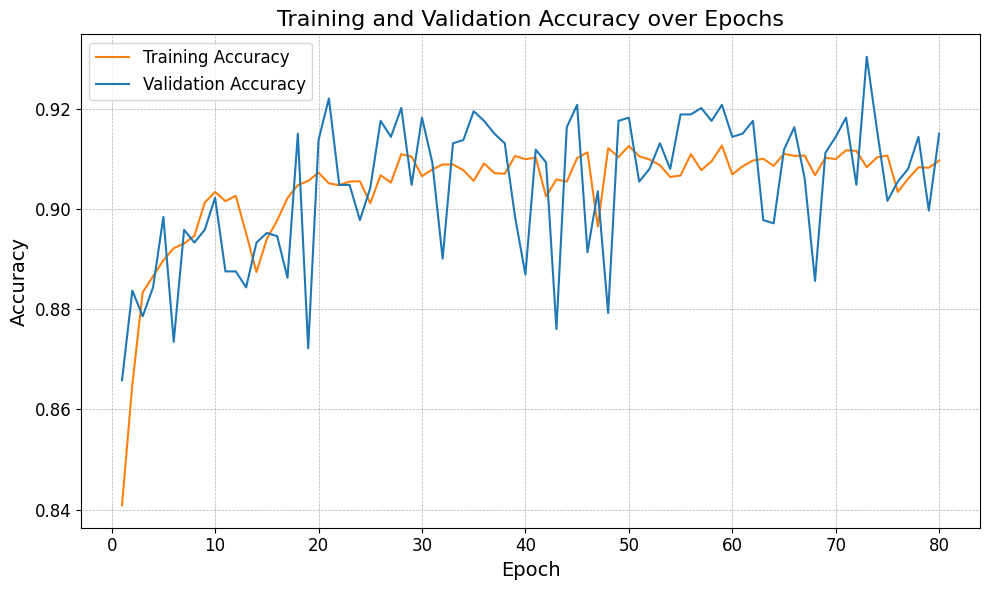

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cnn_results.csv')

epochs = df.index + 1
training_accuracy = df["Training Accuracy"]
validation_accuracy = df["Validation Accuracy"]

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, label='Training Accuracy', color='#ff7f0e')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='#1f77b4')
plt.title('Training and Validation Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


# R18

In [7]:

resnet18 = models.resnet18(pretrained=True)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)  # 两个类别：fire和non-fire

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001) 

epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    resnet18.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    resnet18.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

for i in range(epochs):
    print(f"Epoch {i+1}, Training Accuracy: {train_accuracies[i]:.4f}, Validation Accuracy: {val_accuracies[i]:.4f}")


Epoch [1/100] - Loss: 0.3785, Training Accuracy: 0.8370
Validation Accuracy: 0.9342
Epoch [2/100] - Loss: 0.3601, Training Accuracy: 0.8523
Validation Accuracy: 0.9387
Epoch [3/100] - Loss: 0.3579, Training Accuracy: 0.8537
Validation Accuracy: 0.9335
Epoch [4/100] - Loss: 0.3610, Training Accuracy: 0.8489
Validation Accuracy: 0.9380
Epoch [5/100] - Loss: 0.3616, Training Accuracy: 0.8536
Validation Accuracy: 0.9425
Epoch [6/100] - Loss: 0.3464, Training Accuracy: 0.8594
Validation Accuracy: 0.9304
Epoch [7/100] - Loss: 0.3608, Training Accuracy: 0.8535
Validation Accuracy: 0.9438
Epoch [8/100] - Loss: 0.3583, Training Accuracy: 0.8530
Validation Accuracy: 0.9546
Epoch [9/100] - Loss: 0.3567, Training Accuracy: 0.8508
Validation Accuracy: 0.9450
Epoch [10/100] - Loss: 0.3546, Training Accuracy: 0.8534
Validation Accuracy: 0.8907
Epoch [11/100] - Loss: 0.3567, Training Accuracy: 0.8562
Validation Accuracy: 0.9163
Epoch [12/100] - Loss: 0.3529, Training Accuracy: 0.8569
Validation Accura

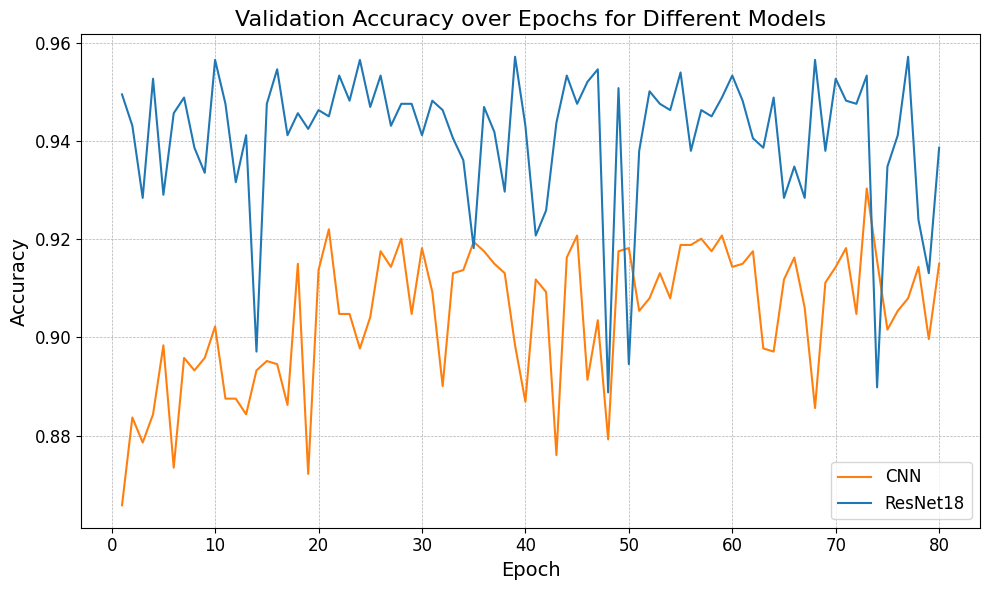

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

df_1 = pd.read_csv('l2_training_results_1.csv')

epochs = df.index + 1
accuracy_1 = df["Validation Accuracy"]
accuracy_2 = df_1["Validation Accuracy"]

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_1, label='CNN', color='#ff7f0e')
plt.plot(epochs, accuracy_2, label='ResNet18', color='#1f77b4')
plt.title('Validation Accuracy over Epochs for Different Models', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


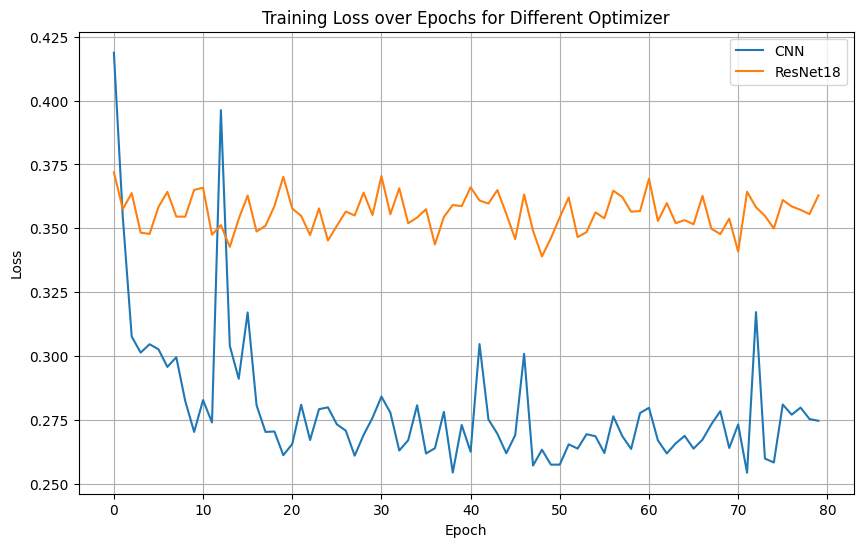

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

loss_1 = df['Training Loss'][:80]
loss_2 = df_1['Training Loss'][:80]

plt.figure(figsize=(10, 6))

plt.plot(loss_1, label="CNN")
plt.plot(loss_2, label="ResNet18")


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for Different Optimizer')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import pandas as pd 
criterion = nn.CrossEntropyLoss()

learning_rates = [0.01, 0.001, 0.0001]

all_train_losses = {}
all_val_accuracies = {}

for lr in learning_rates:
    print(f"Training with Learning Rate: {lr}")

    resnet18 = models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)
    resnet18 = resnet18.to(device)

    optimizer = optim.Adam(resnet18.fc.parameters(), lr=lr)

    train_losses = []
    val_accuracies = []

    epochs = 100
    for epoch in range(epochs):
        resnet18.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        resnet18.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = resnet18(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

    all_train_losses[lr] = train_losses
    all_val_accuracies[lr] = val_accuracies

df_losses = pd.DataFrame(all_train_losses)
df_accuracies = pd.DataFrame(all_val_accuracies)

df_losses.to_csv("train_losses.csv", index=False)
df_accuracies.to_csv("val_accuracies.csv", index=False)


Training with Learning Rate: 0.01


c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training with Learning Rate: 0.001
Training with Learning Rate: 0.0001


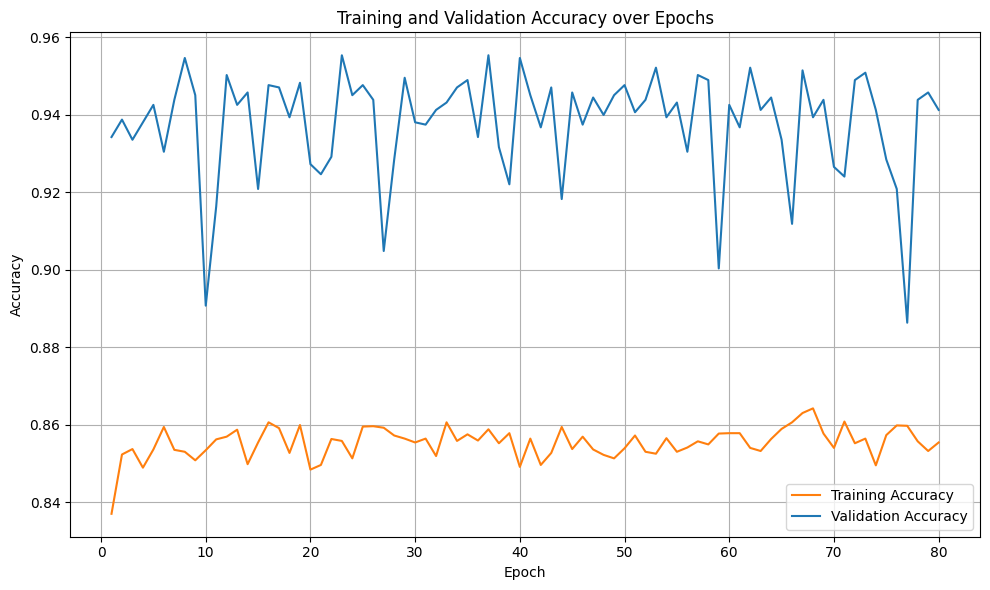

In [13]:
import matplotlib.pyplot as plt

epochs = list(range(1, 81))

train_accs_80 = train_accs[:80]
val_accs_80 = val_accs[:80]

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_accs_80, label='Training Accuracy', color='#ff7f0e')  # 蓝色
plt.plot(epochs, val_accs_80, label='Validation Accuracy', color='#1f77b4')  # 橙色

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


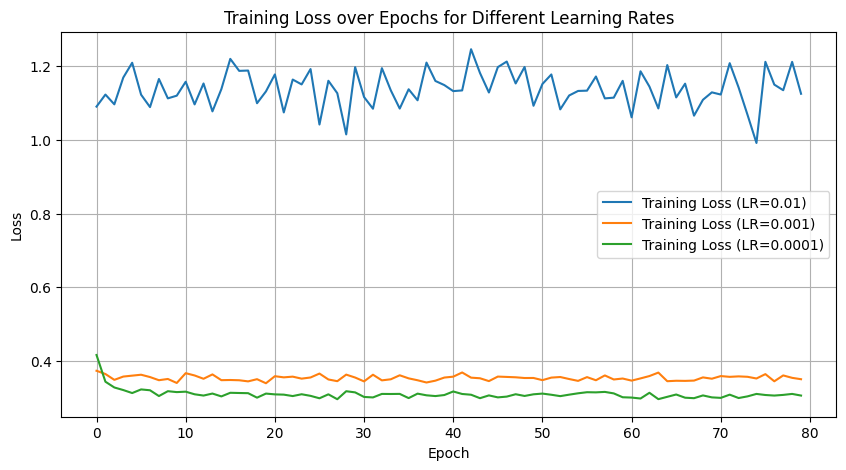

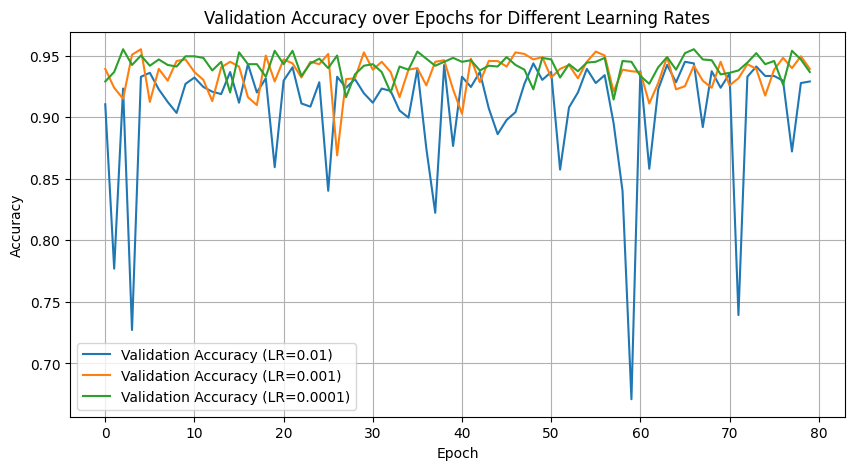

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

train_losses = pd.read_csv('train_losses.csv')
val_accuracies = pd.read_csv('val_accuracies.csv')

plt.figure(figsize=(10,5))
for lr in [0.01, 0.001, 0.0001]:
    plt.plot(train_losses[str(lr)][:80], label=f'Training Loss (LR={lr})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
for lr in [0.01, 0.001, 0.0001]:
    plt.plot(val_accuracies[str(lr)][:80], label=f'Validation Accuracy (LR={lr})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

results_df = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Training Accuracy', 'Validation Accuracy'])

resnet18 = models.resnet18(pretrained=True)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_l2 = optim.Adam(resnet18.fc.parameters(), lr=0.001, weight_decay=0.0001)  # 添加weight_decay参数

epochs = 80
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    resnet18.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_l2.zero_grad()
        outputs = resnet18(inputs)
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_l2.step()
        running_loss += loss.item()

    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    resnet18.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    new_row = pd.DataFrame({
        'Epoch': [epoch + 1],
        'Training Loss': [avg_train_loss],
        'Training Accuracy': [train_accuracy],
        'Validation Accuracy': [val_accuracy]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)


results_df.to_csv('l2_training_results_01.csv', index=False)

c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/80] - Loss: 0.3719, Training Accuracy: 0.8394
Validation Accuracy: 0.9470


C:\Users\64985\AppData\Local\Temp\ipykernel_27768\1957109517.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Epoch [2/80] - Loss: 0.3575, Training Accuracy: 0.8503
Validation Accuracy: 0.9284
Epoch [3/80] - Loss: 0.3638, Training Accuracy: 0.8496
Validation Accuracy: 0.9220
Epoch [4/80] - Loss: 0.3483, Training Accuracy: 0.8584
Validation Accuracy: 0.9380
Epoch [5/80] - Loss: 0.3478, Training Accuracy: 0.8572
Validation Accuracy: 0.9527
Epoch [6/80] - Loss: 0.3584, Training Accuracy: 0.8510
Validation Accuracy: 0.9118
Epoch [7/80] - Loss: 0.3643, Training Accuracy: 0.8471
Validation Accuracy: 0.9438
Epoch [8/80] - Loss: 0.3546, Training Accuracy: 0.8552
Validation Accuracy: 0.9355
Epoch [9/80] - Loss: 0.3546, Training Accuracy: 0.8545
Validation Accuracy: 0.9514
Epoch [10/80] - Loss: 0.3650, Training Accuracy: 0.8519
Validation Accuracy: 0.8965
Epoch [11/80] - Loss: 0.3659, Training Accuracy: 0.8488
Validation Accuracy: 0.9329
Epoch [12/80] - Loss: 0.3475, Training Accuracy: 0.8576
Validation Accuracy: 0.9406
Epoch [13/80] - Loss: 0.3513, Training Accuracy: 0.8562
Validation Accuracy: 0.9470


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

results_df = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Training Accuracy', 'Validation Accuracy'])

resnet18 = models.resnet18(pretrained=True)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_l2 = optim.Adam(resnet18.fc.parameters(), lr=0.001, weight_decay=0.0001)  # 添加weight_decay参数

epochs = 80
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    resnet18.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_l2.zero_grad()
        outputs = resnet18(inputs)
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_l2.step()
        running_loss += loss.item()

    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    resnet18.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    new_row = pd.DataFrame({
        'Epoch': [epoch + 1],
        'Training Loss': [avg_train_loss],
        'Training Accuracy': [train_accuracy],
        'Validation Accuracy': [val_accuracy]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)


results_df.to_csv('l2_training_results_01.csv', index=False)

# SGD

In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

results_df = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Training Accuracy', 'Validation Accuracy'])

resnet18 = models.resnet18(pretrained=True)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_l2 = optim.SGD(resnet18.fc.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001, nesterov=True)  # 添加weight_decay参数

epochs = 80
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    resnet18.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_l2.zero_grad()
        outputs = resnet18(inputs)
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_l2.step()
        running_loss += loss.item()

    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    resnet18.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    new_row = pd.DataFrame({
        'Epoch': [epoch + 1],
        'Training Loss': [avg_train_loss],
        'Training Accuracy': [train_accuracy],
        'Validation Accuracy': [val_accuracy]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.to_csv('sgd_results_01.csv', index=False)

c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/80] - Loss: 0.3770, Training Accuracy: 0.8383
Validation Accuracy: 0.9297


C:\Users\64985\AppData\Local\Temp\ipykernel_5808\3444352084.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Epoch [2/80] - Loss: 0.3274, Training Accuracy: 0.8653
Validation Accuracy: 0.9323
Epoch [3/80] - Loss: 0.3193, Training Accuracy: 0.8659
Validation Accuracy: 0.9419
Epoch [4/80] - Loss: 0.3238, Training Accuracy: 0.8638
Validation Accuracy: 0.9399
Epoch [5/80] - Loss: 0.3213, Training Accuracy: 0.8650
Validation Accuracy: 0.9374
Epoch [6/80] - Loss: 0.3133, Training Accuracy: 0.8702
Validation Accuracy: 0.9367
Epoch [7/80] - Loss: 0.3191, Training Accuracy: 0.8681
Validation Accuracy: 0.9387
Epoch [8/80] - Loss: 0.3169, Training Accuracy: 0.8642
Validation Accuracy: 0.9540
Epoch [9/80] - Loss: 0.3190, Training Accuracy: 0.8667
Validation Accuracy: 0.9482
Epoch [10/80] - Loss: 0.3195, Training Accuracy: 0.8655
Validation Accuracy: 0.9227
Epoch [11/80] - Loss: 0.3151, Training Accuracy: 0.8709
Validation Accuracy: 0.9419
Epoch [12/80] - Loss: 0.3077, Training Accuracy: 0.8721
Validation Accuracy: 0.9316
Epoch [13/80] - Loss: 0.3206, Training Accuracy: 0.8647
Validation Accuracy: 0.9329


# Adagrad

In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

results_df = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Training Accuracy', 'Validation Accuracy'])

resnet18 = models.resnet18(pretrained=True)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_l2 = optim.Adagrad(resnet18.fc.parameters(), lr=0.0001, weight_decay=0.0001) 

epochs = 80
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    resnet18.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_l2.zero_grad()
        outputs = resnet18(inputs)
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_l2.step()
        running_loss += loss.item()

    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    resnet18.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    new_row = pd.DataFrame({
        'Epoch': [epoch + 1],
        'Training Loss': [avg_train_loss],
        'Training Accuracy': [train_accuracy],
        'Validation Accuracy': [val_accuracy]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)


results_df.to_csv('ada_results_01.csv', index=False)

c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/80] - Loss: 0.6348, Training Accuracy: 0.6394
Validation Accuracy: 0.6850


C:\Users\64985\AppData\Local\Temp\ipykernel_5808\3636904933.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Epoch [2/80] - Loss: 0.5963, Training Accuracy: 0.6815
Validation Accuracy: 0.7137
Epoch [3/80] - Loss: 0.5753, Training Accuracy: 0.7080
Validation Accuracy: 0.7246
Epoch [4/80] - Loss: 0.5624, Training Accuracy: 0.7281
Validation Accuracy: 0.7732
Epoch [5/80] - Loss: 0.5487, Training Accuracy: 0.7431
Validation Accuracy: 0.7962
Epoch [6/80] - Loss: 0.5381, Training Accuracy: 0.7520
Validation Accuracy: 0.7668
Epoch [7/80] - Loss: 0.5364, Training Accuracy: 0.7566
Validation Accuracy: 0.8166
Epoch [8/80] - Loss: 0.5236, Training Accuracy: 0.7690
Validation Accuracy: 0.8153
Epoch [9/80] - Loss: 0.5169, Training Accuracy: 0.7749
Validation Accuracy: 0.8358
Epoch [10/80] - Loss: 0.5122, Training Accuracy: 0.7754
Validation Accuracy: 0.7981
Epoch [11/80] - Loss: 0.5050, Training Accuracy: 0.7822
Validation Accuracy: 0.8288
Epoch [12/80] - Loss: 0.4980, Training Accuracy: 0.7939
Validation Accuracy: 0.8173
Epoch [13/80] - Loss: 0.4951, Training Accuracy: 0.7917
Validation Accuracy: 0.8332


# Optimizer

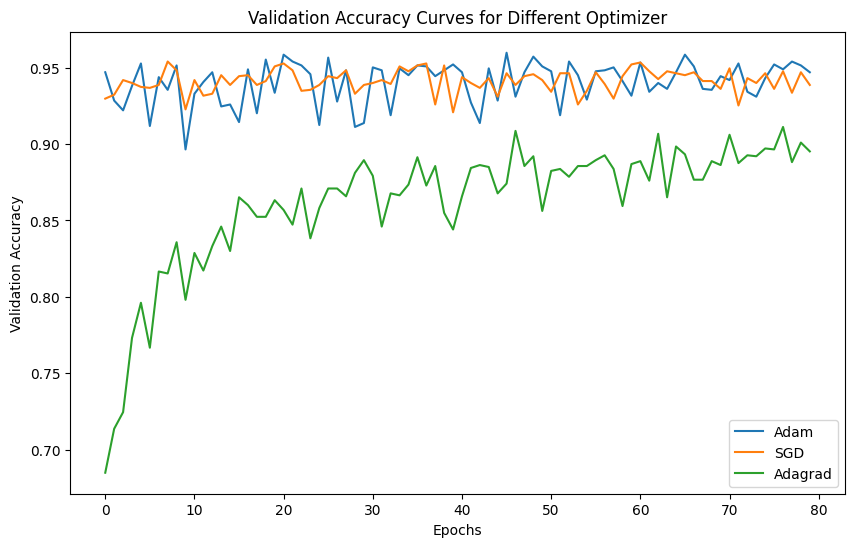

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

val_accuracies_df = pd.read_csv('l2_training_results_01.csv')
training_results_df = pd.read_csv('sgd_results_01.csv')
training_results_1_df = pd.read_csv('ada_results_01.csv')

val_accuracies_data = val_accuracies_df["Validation Accuracy"][:80]
training_results_data = training_results_df["Validation Accuracy"][:80]
training_results_1_data = training_results_1_df["Validation Accuracy"][:80]

plt.figure(figsize=(10, 6))

plt.plot(val_accuracies_data, label="Adam")
plt.plot(training_results_data, label="SGD")
plt.plot(training_results_1_data, label="Adagrad")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Curves for Different Optimizer")
plt.legend()

plt.show()


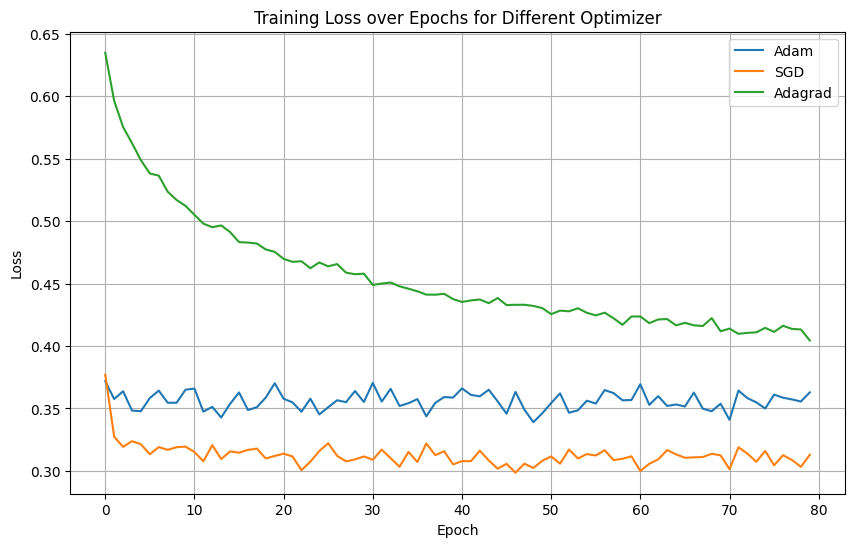

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

val_accuracies_df = pd.read_csv('l2_training_results_01.csv')
training_results_df = pd.read_csv('sgd_results_01.csv')
training_results_1_df = pd.read_csv('ada_results_01.csv')

loss_1_data = val_accuracies_df['Training Loss'][:80]
loss_2_data = training_results_df['Training Loss'][:80]
loss_3_data = training_results_1_df['Training Loss'][:80]

plt.figure(figsize=(10, 6))

plt.plot(loss_1_data, label="Adam")
plt.plot(loss_2_data, label="SGD")
plt.plot(loss_3_data, label="Adagrad")


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for Different Optimizer')
plt.legend()
plt.grid(True)
plt.show()
